In [1]:
############################## TO DO LIST: ############################
# Avaliar:
##Estrangeiros por filme?
##Meses de lançamento dos filmes mais bem avaliados + correlação?
##################################################################################
#                                                                                 #
#Trabalho Final das Disciplinas Estatística Aplicada e Programação com R e Python #
#Discentes: Isabella Calfa e Taian Feitosa                                        #
#                                                                                 #
###################################################################################

In [2]:
import locale
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession

In [3]:
# Para salvar os gráficos depois
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "graficos")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Fonte do plot
locale.setlocale(locale.LC_NUMERIC, "pt_br")
plt.rcParams.update({'font.size': 16})


In [4]:
movies_dataframe = pd.read_csv("IMDb movies.csv", low_memory=False, skipinitialspace=True)
ratings_dataframe = pd.read_csv("IMDb ratings.csv", skipinitialspace=True)
# Join do dataframe de filmes com as suas notas
imdb_df = pd.merge(movies_dataframe, ratings_dataframe, on=["imdb_title_id"])

In [5]:
# Limpar espaços em brancos no início e fim dos nomes
cols = imdb_df.select_dtypes(['object']).columns
imdb_df[cols] = imdb_df[cols].apply(lambda x: x.str.strip())
imdb_df.describe().round(1)

,duration,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,weighted_average_vote,total_votes,mean_vote,median_vote,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
count,85855.0,85855.0,85855.0,13305.0,78258.0,74058.0,85855.0,85855.0,85855.0,85855.0,...,84911.0,84911.0,83057.0,83057.0,85176.0,85176.0,85646.0,85646.0,85854.0,85854.0
mean,100.4,5.9,9493.5,55.9,46.0,27.5,5.9,9493.5,6.2,6.3,...,6.1,685.7,6.0,196.1,5.2,76.1,5.9,1647.8,5.7,4332.9
std,22.6,1.2,53574.4,17.8,178.5,58.3,1.2,53574.4,1.2,1.5,...,1.5,3732.4,1.5,843.0,1.3,124.3,1.3,8456.0,1.3,23243.8
min,41.0,1.0,99.0,1.0,1.0,1.0,1.0,99.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,88.0,5.2,205.0,43.0,4.0,3.0,5.2,205.0,5.6,6.0,...,5.3,10.0,5.2,6.0,4.4,11.0,5.2,24.0,5.0,95.0
50%,96.0,6.1,484.0,57.0,9.0,8.0,6.1,484.0,6.4,6.0,...,6.3,27.0,6.2,16.0,5.3,29.0,6.1,81.0,6.0,225.0
75%,108.0,6.8,1766.5,69.0,27.0,23.0,6.8,1766.5,7.0,7.0,...,7.0,109.0,7.0,62.0,6.0,77.0,6.8,335.0,6.7,841.0
max,808.0,9.9,2278845.0,100.0,10472.0,999.0,9.9,2278845.0,9.8,10.0,...,10.0,129249.0,10.0,34317.0,10.0,928.0,10.0,348363.0,10.0,887226.0


In [6]:
# Ajuste dos tipos de variáveis:
imdb_df["country"] = imdb_df["country"].astype(str)
imdb_df["production_company"] = imdb_df["production_company"].astype(str)

In [7]:
# Filmes sem países:
no_country = len(imdb_df[imdb_df["country"] == "nan"])
print(f'Filmes sem países: {no_country}')

Filmes sem países: 64


In [8]:
# Conversão pela moda:
country_by_company = imdb_df.groupby(["production_company"])["country"].agg([pd.Series.mode])
country_by_company["mode_string"] = country_by_company["mode"].apply(lambda x: x[0] if len(x[0]) > 1 else x)
imdb_df = pd.merge(imdb_df, country_by_company, how='left', on="production_company")
imdb_df["country"] = np.select([imdb_df["country"] == "nan"], [imdb_df["mode_string"]], default=imdb_df["country"])

In [9]:
# Filmes sem países pós correção:
no_country = len(imdb_df[imdb_df["country"] == "nan"])
print(f'Filmes sem países pós correção por companhia: {no_country}')

Filmes sem países pós correção por companhia: 26


In [10]:
# Quantidade de países do filme:
imdb_df["n_country"] = imdb_df["country"].astype(str).str.count(',') + 1
# Primeiro país do filme:
imdb_df["first_country"] = imdb_df["country"].astype(str).str.split(',').str[0]

In [11]:
# Filmes sem idioma:
no_language = imdb_df[imdb_df["language"].isnull()].count()
print(f'Filmes sem idioma: {no_language["imdb_title_id"]}')

Filmes sem idioma: 833


In [12]:
no_language_no_country = imdb_df[(imdb_df["country"] == "nan") & (imdb_df["language"].isnull())].count()
print(f'Filmes sem países e sem idioma: {no_language_no_country["imdb_title_id"]}')

Filmes sem países e sem idioma: 6


In [13]:
# Ajuste dos tipos de variáveis:
imdb_df["language"] = imdb_df["language"].astype(str)

In [14]:
# Moda do idioma por país do filme que produz:
modal_language_by_country = imdb_df.groupby(["country"])["language"].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame(
    name='new_language')
imdb_df = pd.merge(imdb_df, modal_language_by_country, how='left', on="country")
imdb_df["language"] = np.select([imdb_df["language"] == "nan"], [imdb_df["new_language"]], default=imdb_df["language"])

In [15]:
no_language = len(imdb_df[imdb_df["language"] == "nan"])
print(f'Filmes sem países pós correção por companhia: {no_language}')
# Quantidade de países do filme:
imdb_df["n_language"] = imdb_df["language"].astype(str).str.count(',') + 1
# Primeiro país do filme:
imdb_df["first_language"] = imdb_df["language"].astype(str).str.split(',').str[0]

Filmes sem países pós correção por companhia: 19


In [16]:
# Quantidade de países do filme:
imdb_df["n_genre"] = imdb_df["genre"].astype(str).str.count(',') + 1
# Primeiro país do filme:
imdb_df["first_genre"] = imdb_df["genre"].astype(str).str.split(',').str[0]

In [17]:
imdb_df.loc[imdb_df["imdb_title_id"] == "tt8206668", "date_published"] = "2019-09-08"
imdb_df.loc[imdb_df["imdb_title_id"] == "tt8206668", "year"] = 2019
imdb_df["date_published"] = pd.to_datetime(imdb_df["date_published"], errors="ignore")

In [18]:
# correção de anos:
imdb_df["year"] = pd.to_numeric(imdb_df["year"], errors="coerce")
imdb_df["decade"] = imdb_df["year"] // 10 * 10
imdb_df["decade"] = imdb_df["decade"].astype(int)
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85855 entries, 0 to 85854
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   imdb_title_id              85855 non-null  object        
 1   title                      85855 non-null  object        
 2   original_title             85855 non-null  object        
 3   year                       85855 non-null  int64         
 4   date_published             85855 non-null  datetime64[ns]
 5   genre                      85855 non-null  object        
 6   duration                   85855 non-null  int64         
 7   country                    85855 non-null  object        
 8   language                   85855 non-null  object        
 9   director                   85768 non-null  object        
 10  writer                     84283 non-null  object        
 11  production_company         85855 non-null  object        
 12  acto

In [19]:
# Nota Arredondada:
imdb_df["round_vote"] = round(imdb_df["avg_vote"], 0)
imdb_df["round_vote"] = imdb_df["round_vote"].astype(int)
imdb_df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,mode_string,n_country,first_country,new_language,n_language,first_language,n_genre,first_genre,decade,round_vote
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,USA,1,USA,English,1,None,1,Romance,1890,6
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,Australia,1,Australia,English,1,None,3,Biography,1900,6
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",German,Urban Gad,...,"Germany, Denmark",2,Germany,German,1,German,1,Drama,1910,6
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,USA,1,USA,English,1,English,2,Drama,1910,5
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,Italy,1,Italy,Italian,1,Italian,3,Adventure,1910,7


In [20]:
# Extração dos meses
imdb_df['month'] = pd.DatetimeIndex(imdb_df['date_published']).month

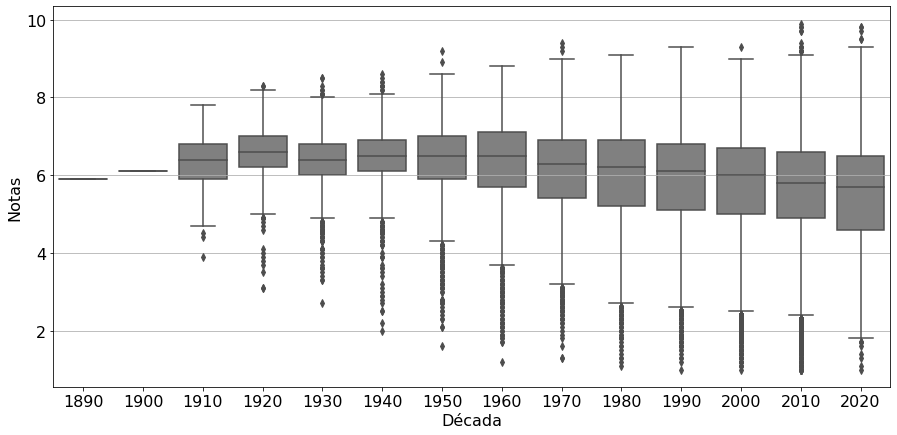

In [21]:
# Boxplot - Notas por Década:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid()
sns.boxplot(x="decade", y="avg_vote", data=imdb_df, color='gray')
ax.set(xlabel='Década', ylabel='Notas')
plt.savefig(os.path.join(IMAGES_PATH, "notas_decada.png"), bbox_inches='tight')

In [22]:
# Boxplot - Bilheteria por Nota:
# plt.subplots(figsize=(15, 7))
# plt.grid()
# imdb_df["worlwide_gross_income"]=imdb_df["worlwide_gross_income"].apply(lambda x: str(x).strip("$ "))
# imdb_df["worlwide_gross_income"]
# df_vote_gross = imdb_df.groupby(["round_vote"]).agg({"worlwide_gross_income": "mean"})
# df_vote_gross.head()
# sns.boxplot(x="round_vote", y="worlwide_gross_income", data=imdb_df, color='gray')

In [23]:
# Dados por década
imdb_df.groupby(['decade'])['avg_vote'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
decade,,,,,,,,
1890,1.0,5.90,NaN,5.9,5.9,5.9,5.9,5.9
1900,1.0,6.10,NaN,6.1,6.1,6.1,6.1,6.1
1910,204.0,6.30,0.65,3.9,5.9,6.4,6.8,7.8
1920,673.0,6.58,0.74,3.1,6.2,6.6,7.0,8.3
1930,2710.0,6.37,0.70,2.7,6.0,6.4,6.8,8.5
1940,2973.0,6.49,0.70,2.0,6.1,6.5,6.9,8.6
1950,4063.0,6.41,0.87,1.6,5.9,6.5,7.0,9.2
1960,4966.0,6.33,1.05,1.2,5.7,6.5,7.1,8.8
1970,6232.0,6.12,1.14,1.3,5.4,6.3,6.9,9.4


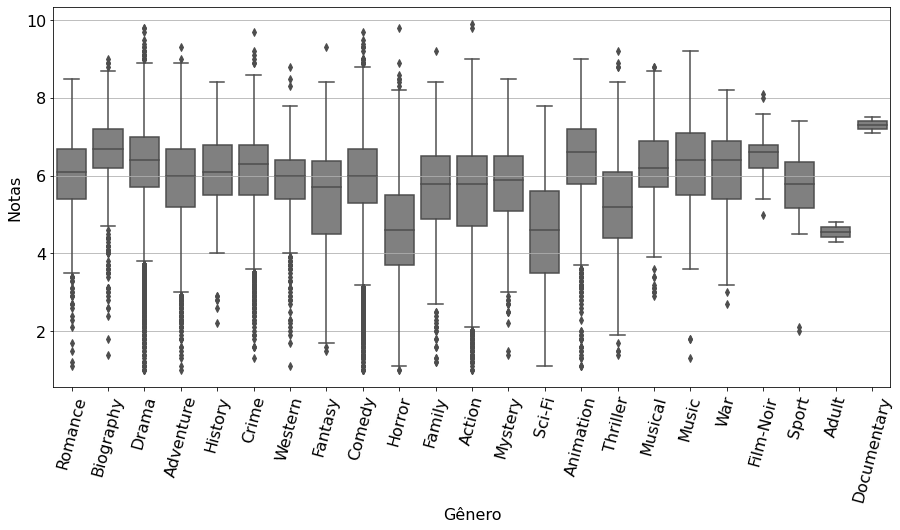

In [24]:
# Boxplot - Notas por gênero:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid()
sns.boxplot(x="first_genre", y="avg_vote", data=imdb_df, color='gray')
ax.set(xlabel='Gênero', ylabel='Notas')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'notas_genero.png'), bbox_inches='tight')

In [25]:
# Dados por gênero
df_genre_vote = imdb_df.groupby(['first_genre'])['avg_vote'].describe().round(1).sort_values(by=['mean'],
                                                                                             ascending=False)
df_genre_vote

,count,mean,std,min,25%,50%,75%,max
first_genre,,,,,,,,
Documentary,2.0,7.3,0.3,7.1,7.2,7.3,7.4,7.5
Film-Noir,29.0,6.6,0.7,5.0,6.2,6.6,6.8,8.1
Biography,2067.0,6.6,0.9,1.4,6.2,6.7,7.2,9.0
Animation,2108.0,6.4,1.2,1.1,5.8,6.6,7.2,9.0
Music,77.0,6.3,1.5,1.3,5.5,6.4,7.1,9.2
Drama,25386.0,6.3,1.0,1.0,5.7,6.4,7.0,9.8
Musical,324.0,6.2,1.0,2.9,5.7,6.2,6.9,8.8
Crime,5557.0,6.1,1.1,1.3,5.5,6.3,6.8,9.7
War,107.0,6.1,1.2,2.7,5.4,6.4,6.9,8.2


<AxesSubplot:xlabel='first_genre', ylabel='avg_vote'>

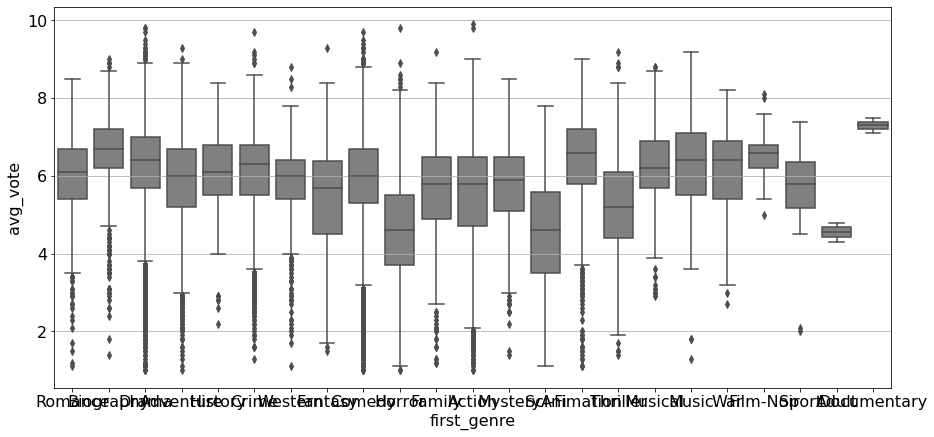

In [26]:
# Nota x gênero
plt.subplots(figsize=(15, 7))
plt.grid()
sns.boxplot(data=imdb_df, x="first_genre", y="avg_vote", color='gray')

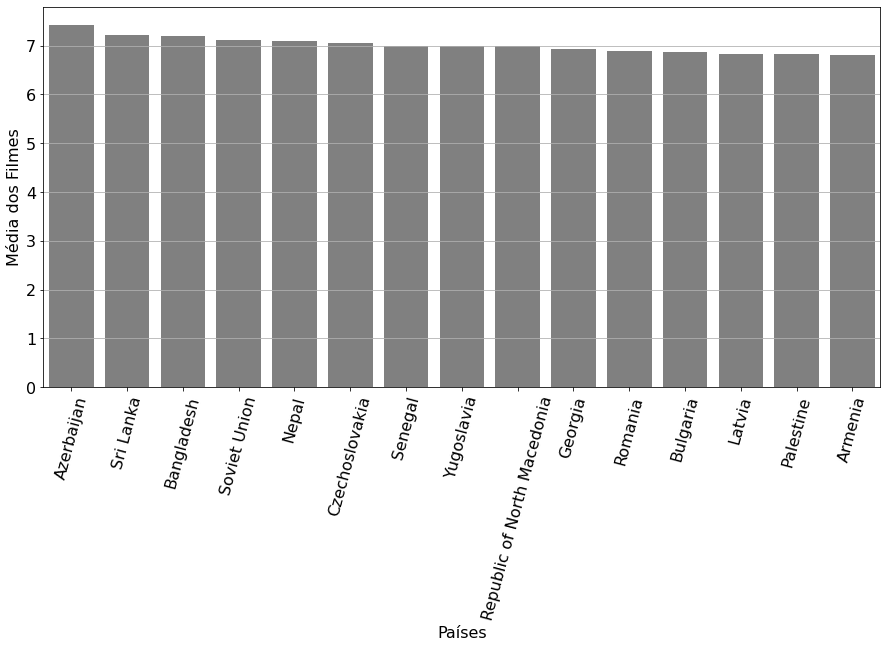

In [27]:
# Notas x País
df1_top_country = imdb_df.groupby(["first_country"]).agg({"avg_vote": ["mean", "count"]})
# df1_top_country.reset_index(inplace=True)
df1_top_country = df1_top_country[df1_top_country["avg_vote"]["count"] >= 10]["avg_vote"].drop(["count"], axis=1)
df1_top_country.sort_values(by='mean', ascending=False, inplace=True)
df1_top_country = df1_top_country.iloc[0:15, :]
plt.subplots(figsize=(15, 7))
plt.grid()
ax = sns.barplot(x=df1_top_country.index, y="mean", data=df1_top_country, color="gray")
ax.set(xlabel='Países', ylabel='Média dos Filmes')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'notas_pais.png'), bbox_inches='tight')

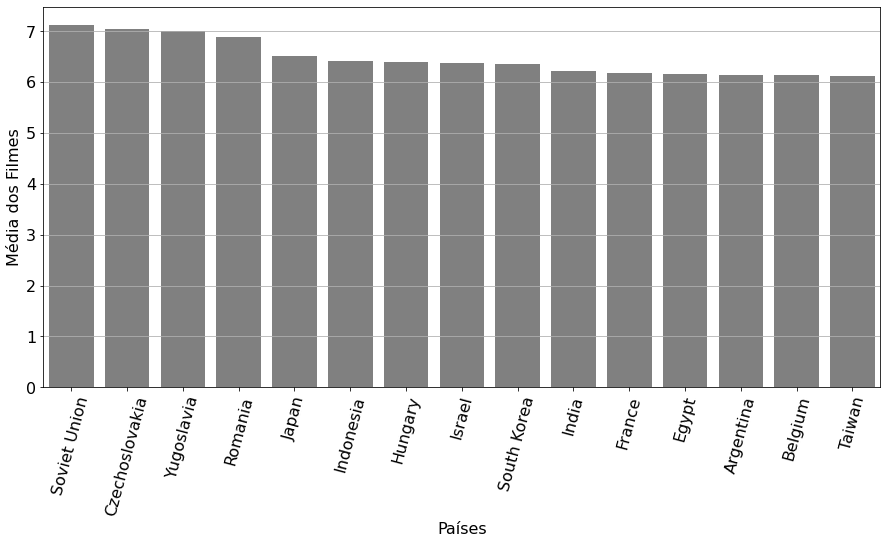

In [28]:
#Ranking de Países que produziram mais de 263 filmes (3º Quartil):
df1_top_country = imdb_df.groupby(["first_country"]).agg({"avg_vote": ["mean", "count"]})
# df1_top_country.reset_index(inplace=True)
df1_top_country = df1_top_country[df1_top_country["avg_vote"]["count"] >= 263]["avg_vote"].drop(["count"], axis=1)
df1_top_country.sort_values(by='mean', ascending=False, inplace=True)
df1_top_country = df1_top_country.iloc[0:15, :]
plt.subplots(figsize=(15, 7))
plt.grid()
ax = sns.barplot(x=df1_top_country.index, y="mean", data=df1_top_country, color="gray")
ax.set(xlabel='Países', ylabel='Média dos Filmes')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'notas_pais_263_filmes.png'), bbox_inches='tight')

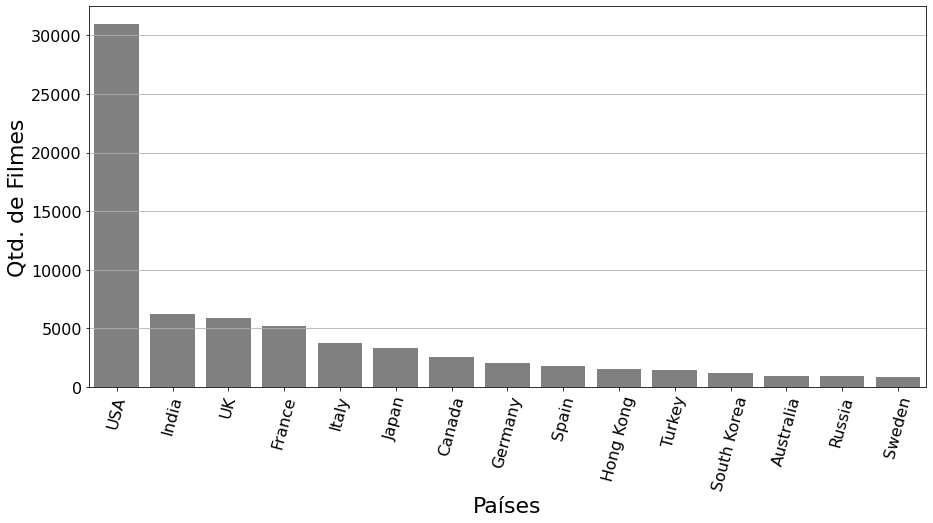

In [29]:
# Filmes x País
df1_top_country = imdb_df.groupby(["first_country"]).agg({"imdb_title_id": "count"})
df1_top_country.reset_index(inplace=True)
df1_top_country.sort_values(by='imdb_title_id', ascending=False, inplace=True)
df1_top_country = df1_top_country.iloc[0:15, :]
plt.subplots(figsize=(15, 7))
plt.grid()
plt.xlabel('País', fontsize=22)
plt.ylabel('Qtd. de Filmes', fontsize=22)
ax = sns.barplot(x="first_country", y="imdb_title_id", data=df1_top_country, order=df1_top_country["first_country"],
                 color="gray")
ax.set(xlabel='Países', ylabel='Qtd. de Filmes')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'filmes_pais.png'), bbox_inches='tight')
# imdb_df["first_country"].describe()


In [30]:
#Ranking de Países:
df1_rank_country = imdb_df.groupby(["first_country"]).agg({"imdb_title_id": "count"})
df1_rank_country.reset_index(inplace=True)
df1_rank_country.sort_values(by='imdb_title_id', ascending=False, inplace=True)
#Países com apenas 1 produção:
df1_rank_country[df1_rank_country['imdb_title_id'] == 1].count()
#Situação do Brasil:
df1_rank_country[df1_rank_country['first_country'] == 'Brazil']
#Ranking 50:
df1_rank_country.head(50)
#Dados Gerais:
df1_rank_country.describe()


,imdb_title_id
count,162.000000
mean,529.969136
std,2574.692078
min,1.000000
25%,4.000000
50%,24.500000
75%,262.250000
max,30937.000000


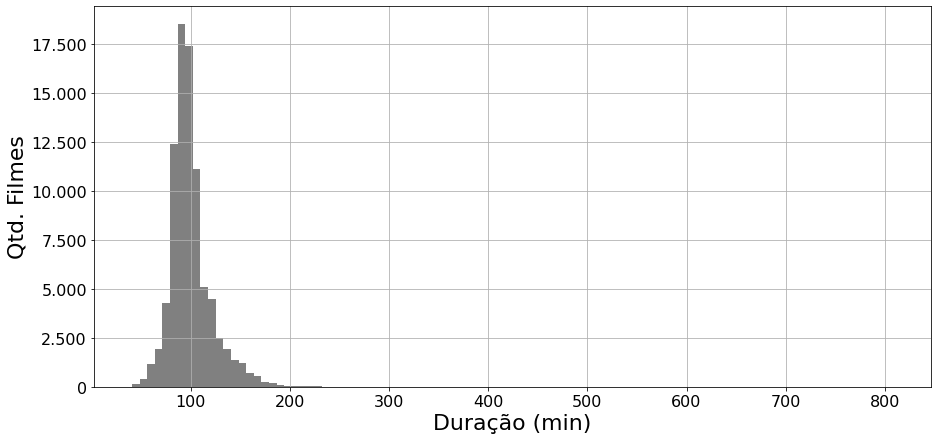

In [31]:
# Duração dos filmes
fig, ax1 = plt.subplots(figsize=(15, 7))
plt.grid()
plt.xlabel('Duração (min)', fontsize=22)
plt.ylabel('Qtd. Filmes', fontsize=22)
plt.hist(imdb_df['duration'], 100, rwidth=1, color='gray')
ax1.ticklabel_format(useLocale=True)
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, loc: locale.format_string('%d', x, 1)))
plt.savefig(os.path.join(IMAGES_PATH, 'duracao_filmes.png'), bbox_inches='tight')
# imdb_df['duration'].describe()


In [32]:
# Duração x gênero
imdb_df.groupby(['first_genre'])['duration'].describe().round(1).sort_values(by=['mean'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
first_genre,,,,,,,,
Biography,2067.0,114.0,25.0,45.0,99.0,110.0,124.0,442.0
History,80.0,109.1,26.7,61.0,93.0,102.5,118.5,205.0
Romance,767.0,108.0,26.9,45.0,90.0,102.0,123.0,278.0
Musical,324.0,107.7,30.3,52.0,88.0,98.5,122.0,247.0
Action,12182.0,107.1,27.7,45.0,90.0,99.0,119.0,421.0
Sport,16.0,105.2,25.2,53.0,89.8,103.0,121.5,165.0
Drama,25386.0,102.9,23.8,45.0,90.0,99.0,111.0,808.0
War,107.0,100.8,20.9,45.0,88.5,98.0,109.5,188.0
Adventure,3599.0,99.1,24.7,45.0,87.0,95.0,106.0,485.0


<AxesSubplot:xlabel='duration_rounded', ylabel='avg_vote'>

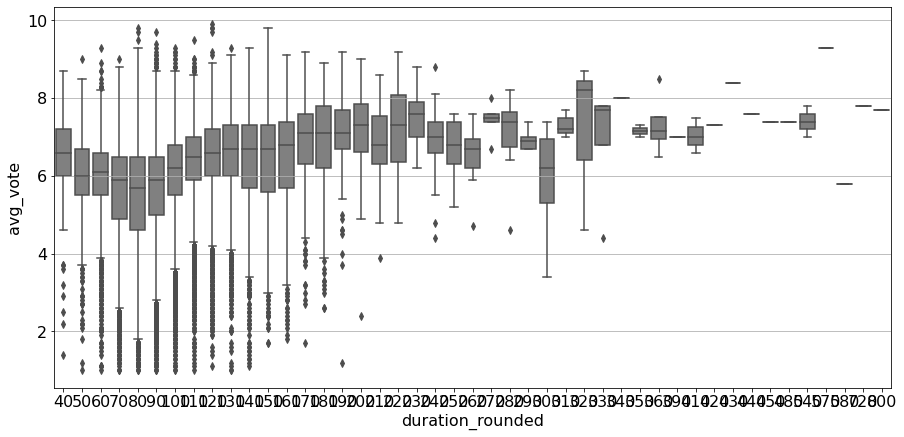

In [33]:
# Notas x Duração
imdb_df["duration_rounded"] = imdb_df["duration"] // 10 * 10
plt.subplots(figsize=(15, 7))
plt.grid()
sns.boxplot(x="duration_rounded", y="avg_vote", data=imdb_df, color='gray')
# Não é uma boa visualização

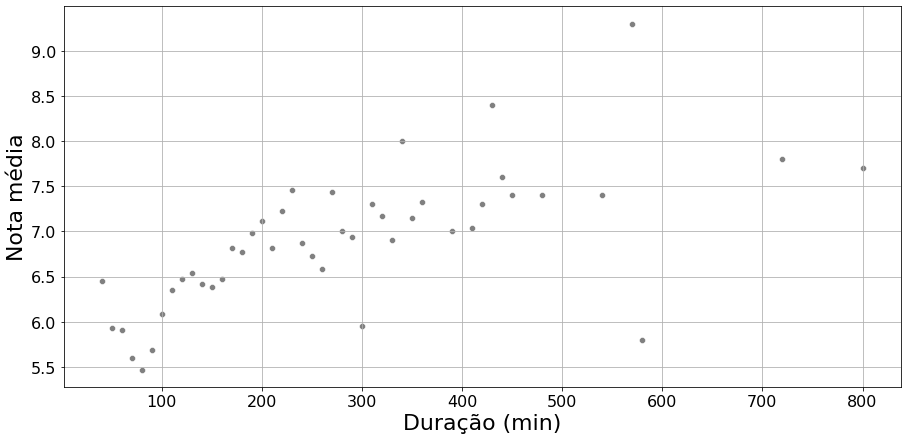

In [34]:
# Notas x Duração
country_by_company = imdb_df.groupby(["duration_rounded"]).agg({"avg_vote": "mean"}).reset_index()
plt.subplots(figsize=(15, 7))
plt.grid()
plt.xlabel('Duração (min)', fontsize=22)
plt.ylabel('Nota média', fontsize=22)
sns.scatterplot(x="duration_rounded", y="avg_vote", data=country_by_company, color='gray')
plt.savefig(os.path.join(IMAGES_PATH, 'notas_duracao.png'), bbox_inches='tight')
# Sem relação direta.

In [35]:
# correlação entre variáveis
# correlation = imdb_df.corr()
# plot = sns.heatmap(correlation, annot=True, fmt=".1f", linewidths=.6)
# plot

<AxesSubplot:>

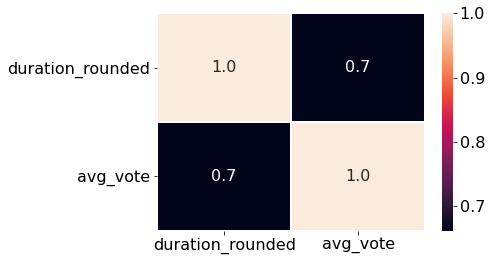

In [36]:
# correlação dentre variáveis duração arredondada por nota média
correlation = country_by_company.corr()
plot = sns.heatmap(correlation, annot=True, fmt=".1f", linewidths=.6)
plot

<AxesSubplot:xlabel='imdb_title_id', ylabel='director'>

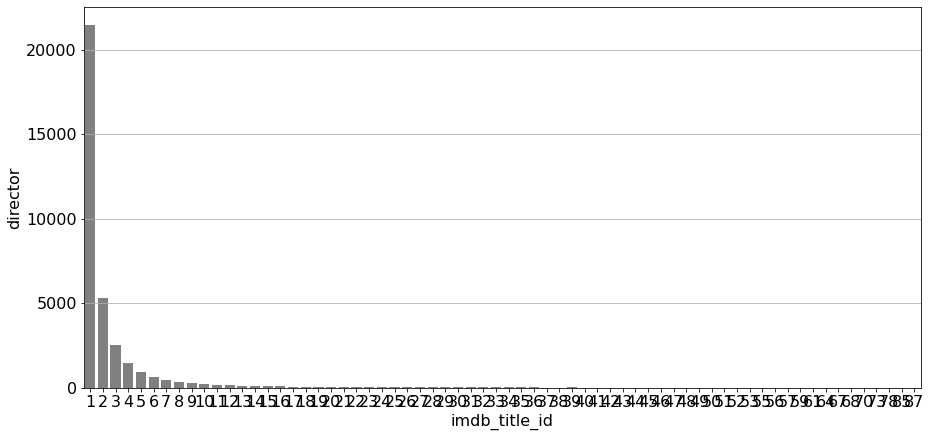

In [37]:
# Quantidade de Filmes x Diretor
imdb_df["director"] = imdb_df["director"].fillna("Non available")
imdb_df["writer"] = imdb_df["writer"].fillna(imdb_df["director"])
dfy = imdb_df.groupby(["director"]).agg({"avg_vote": "mean", "imdb_title_id": "count"}).reset_index()
dfz = dfy.groupby(["imdb_title_id"]).agg({"director": "count"}).reset_index()
dfz.sort_values(by="imdb_title_id", ascending=False)
plt.subplots(figsize=(15, 7))
plt.grid()
sns.barplot(x="imdb_title_id", y="director", data=dfz, color='gray')

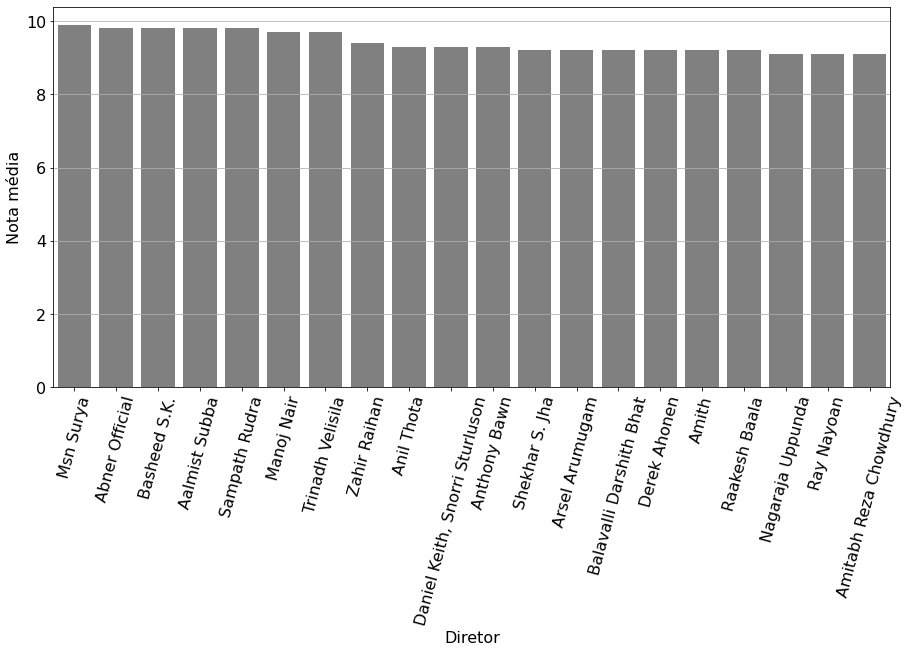

In [38]:
# Melhores diretores
df1_top_director = imdb_df.groupby(["director"]).agg({"avg_vote": "mean","imdb_title_id":"count"})
df1_top_director.reset_index(inplace=True)
df1_top_director.sort_values(by='avg_vote', ascending=False, inplace=True)
df1_top_director = df1_top_director.iloc[0:20, :]
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid()
sns.barplot(x="director", y="avg_vote", data=df1_top_director, order=df1_top_director["director"], color="gray")
ax.set(xlabel='Diretor', ylabel='Nota média')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'melhores_diretores.png'), bbox_inches='tight')

In [39]:
# Incluir rótulos
print(df1_top_director.head(20).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                      director &  avg\_vote &  imdb\_title\_id \\
\midrule
                     Msn Surya &       9.9 &              1 \\
                Abner Official &       9.8 &              1 \\
                  Basheed S.K. &       9.8 &              1 \\
                 Aalmist Subba &       9.8 &              1 \\
                 Sampath Rudra &       9.8 &              1 \\
                    Manoj Nair &       9.7 &              1 \\
              Trinadh Velisila &       9.7 &              1 \\
                  Zahir Raihan &       9.4 &              1 \\
                    Anil Thota &       9.3 &              1 \\
Daniel Keith, Snorri Sturluson &       9.3 &              1 \\
                  Anthony Bawn &       9.3 &              1 \\
                Shekhar S. Jha &       9.2 &              1 \\
                Arsel Arumugam &       9.2 &              1 \\
       Balavalli Darshith Bhat &       9.2 &              1 \\
             

\begin{tabular}{lrr}
\toprule
{} & \multicolumn{2}{l}{avg\_vote} \\
{} &     mean & count \\
director             &          &       \\
\midrule
Upendra              &      8.6 &     5 \\
Vetrimaaran          &      8.2 &     5 \\
Christopher Nolan    &      8.2 &    11 \\
Nikolay Volev        &      8.2 &     5 \\
Tauquir Ahmed        &      8.2 &     5 \\
Rasim Ojagov         &      8.1 &     5 \\
Rajkumar Hirani      &      8.1 &     5 \\
Satyajit Ray         &      8.0 &    28 \\
Andrei Tarkovsky     &      8.0 &     7 \\
Hayao Miyazaki       &      8.0 &    12 \\
Sergio Leone         &      7.9 &     7 \\
Sameer Vidwans       &      7.9 &     5 \\
Slobodan Sijan       &      7.9 &     5 \\
Ivan Andonov         &      7.9 &     5 \\
Humayun Ahmed        &      7.9 &     7 \\
James Cameron        &      7.9 &     7 \\
Quentin Tarantino    &      7.9 &    12 \\
Tengiz Abuladze      &      7.8 &     6 \\
Sergey A.            &      7.8 &    24 \\
Stanislav Rostotskiy &      7.8 &     

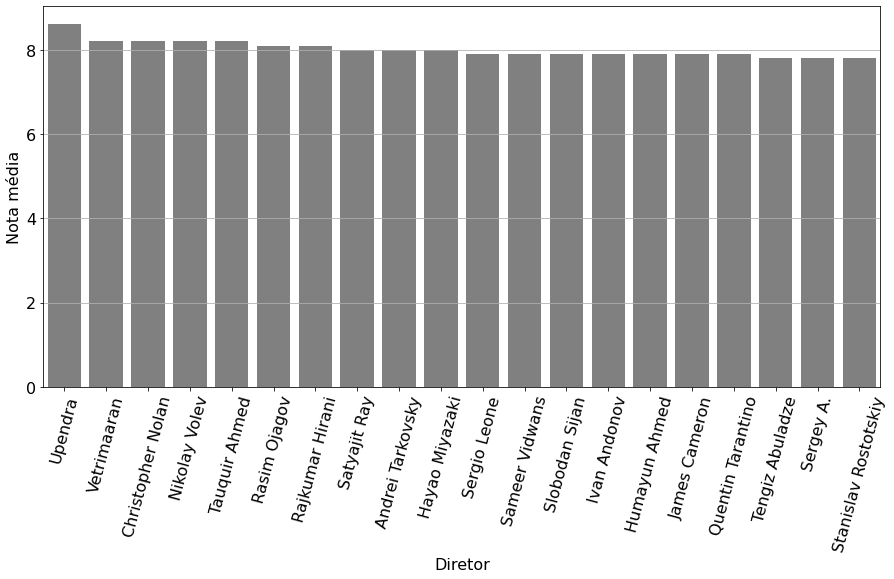

In [40]:
# Diretores com pelo menos 5 filmes
df2_top_director = imdb_df.groupby(["director"]).agg({"avg_vote": ["count"]})
df2_top_director = df2_top_director[df2_top_director["avg_vote"]["count"] >= 5]
df3_top_director = imdb_df[imdb_df["director"].isin(df2_top_director.index)].groupby(["director"]).agg(
    {"avg_vote": ["mean","count"]})
df3_top_director = df3_top_director.sort_values(by=("avg_vote", "mean"), ascending=False).round(1)
df3_top_director = df3_top_director.iloc[0:20, :]
print(df3_top_director.to_latex())
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid()
sns.barplot(x=df3_top_director.index, y=("avg_vote", "mean"), data=df3_top_director, color="gray")
ax.set(xlabel='Diretor', ylabel='Nota média')
plt.xticks(rotation=75)
plt.savefig(os.path.join(IMAGES_PATH, 'melhores_diretores_5_mais.png'), bbox_inches='tight')

In [41]:
# Pensando em modelos de regressão
colunas_relevantes = ['year', 'month', 'duration', 'director', 'production_company', 'avg_vote']

In [42]:
df_colunas_relevantes = imdb_df[colunas_relevantes]
df_colunas_relevantes.isnull().sum()

year                  0
month                 0
duration              0
director              0
production_company    0
avg_vote              0
dtype: int64

In [43]:
# Create PySpark SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "8g").appName(
    "ECD_Trabalho").getOrCreate()
# Create PySpark DataFrame from Pandas
sparkDF = spark.createDataFrame(df_colunas_relevantes)
sparkDF.printSchema()

root
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- director: string (nullable = true)
 |-- production_company: string (nullable = true)
 |-- avg_vote: double (nullable = true)



In [44]:
directorIdx = StringIndexer(inputCol='director', outputCol='directorIdx')
production_company_Idx = StringIndexer(inputCol='production_company', outputCol='production_company_Idx')

In [45]:
onehotencoder_director_vector = OneHotEncoder(inputCol="directorIdx", outputCol="director_vec")
onehotencoder_production_company_vector = OneHotEncoder(inputCol="production_company_Idx",
                                                        outputCol="production_company_vec")

In [46]:
pipeline = Pipeline(stages=[directorIdx,
                            production_company_Idx,
                            onehotencoder_director_vector,
                            onehotencoder_production_company_vector,
                            ])

In [47]:
df_transformed = pipeline.fit(sparkDF).transform(sparkDF)
df_transformed.show()

+----+-----+--------+--------------------+--------------------+--------+-----------+----------------------+--------------------+----------------------+
|year|month|duration|            director|  production_company|avg_vote|directorIdx|production_company_Idx|        director_vec|production_company_vec|
+----+-----+--------+--------------------+--------------------+--------+-----------+----------------------+--------------------+----------------------+
|1894|   10|      45|     Alexander Black|Alexander Black P...|     5.9|    13972.0|               11065.0|(34733,[13972],[1...|  (32050,[11065],[1...|
|1906|   12|      70|        Charles Tait|      J. and N. Tait|     6.1|    16485.0|               21381.0|(34733,[16485],[1...|  (32050,[21381],[1...|
|1911|    8|      53|           Urban Gad|            Fotorama|     5.8|    33485.0|               18875.0|(34733,[33485],[1...|  (32050,[18875],[1...|
|1912|   11|     100|  Charles L. Gaskill|Helen Gardner Pic...|     5.2|    16459.0|    

In [48]:
assembler = VectorAssembler(inputCols=["year", "month", "duration", "director_vec", "production_company_vec"],
                            outputCol="features")
df = assembler.transform(
    df_transformed.select(["year", "month", "duration", "director_vec", "production_company_vec", "avg_vote"]))
df.select(['features', 'avg_vote']).show()

+--------------------+--------+
|            features|avg_vote|
+--------------------+--------+
|(66786,[0,1,2,139...|     5.9|
|(66786,[0,1,2,164...|     6.1|
|(66786,[0,1,2,334...|     5.8|
|(66786,[0,1,2,164...|     5.2|
|(66786,[0,1,2,194...|     7.0|
|(66786,[0,1,2,757...|     5.7|
|(66786,[0,1,2,84,...|     6.8|
|(66786,[0,1,2,189...|     6.2|
|(66786,[0,1,2,148...|     6.7|
|(66786,[0,1,2,144...|     5.5|
|(66786,[0,1,2,843...|     6.6|
|(66786,[0,1,2,923...|     7.0|
|(66786,[0,1,2,725...|     7.1|
|(66786,[0,1,2,923...|     7.0|
|(66786,[0,1,2,259...|     6.2|
|(66786,[0,1,2,140...|     6.5|
|(66786,[0,1,2,923...|     7.0|
|(66786,[0,1,2,215...|     5.8|
|(66786,[0,1,2,286...|     6.5|
|(66786,[0,1,2,963...|     6.0|
+--------------------+--------+
only showing top 20 rows



In [49]:
splits = df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [50]:
lr = LinearRegression(featuresCol='features', labelCol='avg_vote', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: (66786,[0,2],[-0.0015544332500819606,0.002907728986379208])
Intercept: 8.705103858393858


In [51]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "avg_vote", "features").show(5)

+------------------+--------+--------------------+
|        prediction|avg_vote|            features|
+------------------+--------+--------------------+
| 5.945895112784186|     6.1|(66786,[0,1,2,164...|
|6.0804005293525725|     6.2|(66786,[0,1,2,189...|
|6.0920314452980895|     7.5|(66786,[0,1,2,110...|
| 5.993168659761197|     7.0|(66786,[0,1,2,923...|
| 5.991614226511115|     6.2|(66786,[0,1,2,259...|
+------------------+--------+--------------------+
only showing top 5 rows



In [52]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="avg_vote", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.0357486
